In [ ]:
!pip install pytorch-fid
!pip install wget
!pip install unrar

  Created wheel for pytorch-fid: filename=pytorch_fid-0.2.1-py3-none-any.whl size=14835 sha256=74e0cbfd0e200e30cd0151da838e33f2b6b99bcd4c9c1c237e3fcfcce84ab29b
  Stored in directory: /root/.cache/pip/wheels/24/ac/03/c5634775c8a64f702343ef5923278f8d3bb8c651debc4a6890
Successfully built pytorch-fid
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=930ff7a1b18fe847bda0f349d349094abc2f038c032292c62f8dcfb7fe19cc5b
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [ ]:
import os
import shutil
import cupy as cp
import numpy
import math
import matplotlib.pyplot as plt
import torch
from torch import optim
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.utils import make_grid, save_image
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torch.autograd import Variable
from PIL import Image
from pytorch_fid import inception
from scipy import linalg
import wget

In [ ]:
os.mkdir('unfiltered')
data_path = r'./unfiltered'
os.mkdir('filtered')
target_path= r'./filtered'
os.mkdir('examples')
os.mkdir('trained_models')

In [ ]:
URL = "https://drive.google.com/u/0/uc?id=1TQQuT60bddyeGBVfwNOk6nxYavxQdZJD&export=download&confirm=t" 
!wget -O thecarconnectionpicturedataset.rar --no-check-certificate "$URL"

--2022-05-16 18:30:39--  https://drive.google.com/u/0/uc?id=1TQQuT60bddyeGBVfwNOk6nxYavxQdZJD&export=download&confirm=t
Resolving drive.google.com (drive.google.com)... 74.125.142.102, 74.125.142.113, 74.125.142.100, ...
Connecting to drive.google.com (drive.google.com)|74.125.142.102|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://drive.google.com/uc?id=1TQQuT60bddyeGBVfwNOk6nxYavxQdZJD&export=download&confirm=t [following]
--2022-05-16 18:30:39--  https://drive.google.com/uc?id=1TQQuT60bddyeGBVfwNOk6nxYavxQdZJD&export=download&confirm=t
Reusing existing connection to drive.google.com:443.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0o-70-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/bonpfuuqv8a5rfq80glfbv72u5c5e763/1652725800000/01153971418670501229/*/1TQQuT60bddyeGBVfwNOk6nxYavxQdZJD?e=download [following]
--2022-05-16 18:30:39--  https://doc-0o-70-docs.googleusercontent.com/docs/secur

In [ ]:
!unrar x "thecarconnectionpicturedataset.rar" "unfiltered/"

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
Extracting  unfiltered/Toyota_RAV4_2016_25_17_170_25_4_72_65_181_22_AWD_5_4_SUV_FKQ.jpg      91%  OK 
Extracting  unfiltered/Toyota_RAV4_2016_25_17_170_25_4_72_65_181_22_AWD_5_4_SUV_GGR.jpg      91%  OK 
Extracting  unfiltered/Toyota_RAV4_2016_25_17_170_25_4_72_65_181_22_AWD_5_4_SUV_GWL.jpg      91%  OK 
Extracting  unfiltered/Toyota_RAV4_2016_25_17_170_25_4_72_65_181_22_AWD_5_4_SUV_IiW.jpg      91%  OK 
Extracting  unfiltered/Toyota_RAV4_2016_25_17_170_25_4_72_65_181_22_AWD_5_4_SUV_iTX.jpg      91%  OK 
Extracting  unfiltered/Toyota_RAV4_2016_25_17_170_25_4_72_65_181_22_AWD_5_4_SUV_jdQ.jpg      91%  OK 
Extracting  unfiltered/Toyota_RAV4_2016_25_17_170_25_4_72_65_181_22_AWD_5_4_SUV_JFf.jpg      91%  OK 
Extracting  unfiltered/Toyota_RAV4_2016_25_17_170_25_4_72_65_181_22_AWD_5_4_SUV_jpO.jpg      91%  OK 
Extracting  unfiltered/Toyota_RAV4_2016_25_17_1

In [ ]:
listOfFiles = os.listdir(data_path)
car_types= ['Convertible','Pickup','Station Wagon','4dr','3dr','2dr','SUV','Van']  # reszta to 'nan'
car_dictionary = dict.fromkeys(car_types)
for type_of_car in car_types:
    str_match = [s for s in listOfFiles if type_of_car+"_" in s]
    car_dictionary[type_of_car] = str_match
    # ponizej tworzenie folderow z posortwanymi juz zdjeciami typow, czyli tzw. klas
    os.mkdir(os.path.join(target_path,type_of_car))
    target_dir = os.path.join(target_path,type_of_car)
    for fname in str_match:
        # copying the files to the destination directory
        shutil.move(os.path.join(data_path,fname), target_dir)

In [ ]:
# TODO:
cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

cuda
#torch.cuda.get_device_name(0)

True

In [ ]:
## inicjalizacja parametrow
number_of_classes = len(car_types)
number_of_epochs = 5

image_size_width = 320
image_size_height = 200
# na przyszlosc sprobowac dodac paski czarne by nie rozciagac zdjec
image_size=(image_size_width,image_size_height)
channels = 3 # bo RGB
img_shape_tuple = (channels, image_size_width, image_size_height)
# img_shape = Variable(LongTensor(img_shape)).cuda()
img_shape = cp.array([channels, image_size_width, image_size_height])

batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
# Size of z latent vector (i.e. size of generator input)
latent_size = 128  # szum dla generatora

# rozmiar zdjec 320x213 pikseli, niektore na x240 lub x160 piskeli, dlatego niech bedzie 320x200 krakowskim targiem
# no chyba że musimy mieć kwadrat, jest tak podanych wiele przykladow i nie wiem, 
# czy przypadkiem wtedy nie ma siec latwiej sobie podzielic obrazu jesli oba rozmiary sa rowne

# z czego korzystam?
# 1) https://jovian.ai/tvscitechtalk/car-gan
# 2) https://github.com/ozanciga/gans-with-pytorch/blob/master/cgan/cgan.py

# ten poniżej kod bardziej do mnie przemawia jeśli chodzi o definicje dyskryminatora i generatora
# 3) https://github.com/eriklindernoren/PyTorch-GAN/blob/36d3c77e5ff20ebe0aeefd322326a134a279b93e/implementations/cgan/cgan.py#L189

train_ds = ImageFolder(target_path, transform=T.Compose([
    #T.Resize((image_size_width,image_size_height)),
    T.Resize((image_size_height,image_size_width)),
    T.ToTensor(),
    T.Normalize(*stats)])) # normalizacja, zeby dyskryminator mial latwiej-?

## wykorzystanie części zbioru
train_ds.samples = [train_ds.samples[idx] for idx in range(2000)]
train_ds.targets = [train_ds.targets[idx] for idx in range(2000)]
# print(train_ds)

# TODO: czy wgl cos tu dodatkowo ustawiac? # drop_last - true or false?
train_dl = DataLoader(train_ds, batch_size, shuffle=True)


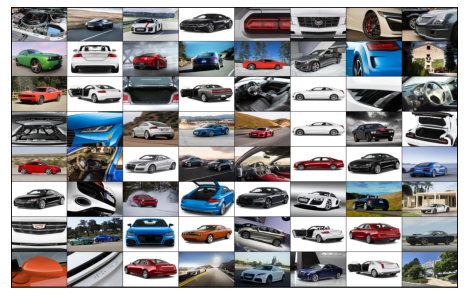

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

show_batch(train_dl)

In [ ]:
## klasa generatora - póki co idea skopiowana z linku 3)
# nn.Module - base class for all neural network modules
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # TODO: okreslic wlasciwe parametry w funkcji ponizej
        # self.label_emb = nn.Embedding(number_of_classes, number_of_classes,device='cuda:0')
        self.label_emb = nn.Embedding(number_of_classes, number_of_classes,device=torch.device('cuda'))
        # TODO: wypróbować Conv2d ale i sprawdzić jak zachowuje sie sieć przy nn.Linear

        def block(in_feat, out_feat, normalize=True):
                # layers = [nn.Linear(in_feat, out_feat)]
                layers = [nn.Linear(in_feat, out_feat)]
                if normalize:
                    layers.append(nn.BatchNorm1d(out_feat, 0.8))
                layers.append(nn.LeakyReLU(0.2, inplace=True))
                return layers

        self.model = nn.Sequential(
            *block(latent_size + number_of_classes, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(cp.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # Concatenate label embedding and image to produce input
        gen_input = torch.cat((self.label_emb(labels).cuda(), noise), -1)
        img = self.model(gen_input.cuda())
        img = img.view(img.size(0), *img_shape_tuple)
        return img

In [ ]:
## klasa dyskryminatora - póki co idea skopiowana z linku 3)
class Discriminator(nn.Module):
    def __init__(self):
            super(Discriminator, self).__init__()

            self.label_embedding = nn.Embedding(number_of_classes, number_of_classes)

            # self.model = nn.Sequential(
            #     # in: 3 x 64 x 64
            #     nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            #     nn.BatchNorm2d(64),
            #     nn.LeakyReLU(0.2, inplace=True),
            #     # out: 64 x 32 x 32

            #     nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            #     nn.BatchNorm2d(128),
            #     nn.LeakyReLU(0.2, inplace=True),
            #     # out: 128 x 16 x 16

            #     nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            #     nn.BatchNorm2d(256),
            #     nn.LeakyReLU(0.2, inplace=True),
            #     # out: 256 x 8 x 8

            #     nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            #     nn.BatchNorm2d(512),
            #     nn.LeakyReLU(0.2, inplace=True),
            #     # out: 512 x 4 x 4

            #     nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            #     # out: 1 x 1 x 1

            #     nn.Flatten(),
            #     nn.Sigmoid()
            # )

            self.model = nn.Sequential(
                nn.Linear(number_of_classes+ int(cp.prod(img_shape)), 512),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Linear(512, 512),
                nn.Dropout(0.4),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Linear(512, 512),
                nn.Dropout(0.4),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Linear(512, 1),
                nn.Sigmoid()
            )

    def forward(self, img, labels):
        # Concatenate label embedding and image to produce input
        d_in = torch.cat((img.view(img.size(0), -1), self.label_embedding(labels)), -1)
        validity = self.model(d_in)
        return validity

In [ ]:
fun_loss = nn.BCELoss() # -> binary cross entropy

device=torch.device('cuda')
# Initialize generator and discriminator
generator = Generator().to(device)
discriminator = Discriminator().to(device)
b1=0.5
b2=0.999
# lrate=0.0002
lrate=0.002
optimizer_D = optim.Adam(discriminator.parameters(), lr=lrate, betas=(b1, b2))
optimizer_G = optim.Adam(generator.parameters(), lr=lrate, betas=(b1, b2))

In [ ]:
def sample_image(n_row, batches_done):
    """Saves a grid of generated digits ranging from 0 to n_classes"""
    # Sample noise
    z = Variable(FloatTensor(cp.random.normal(0, 1, (n_row ** 2, latent_size))))
    # Get labels ranging from 0 to n_classes for n rows
    labels = cp.array([num for _ in range(n_row) for num in range(n_row)])
    labels = Variable(LongTensor(labels))
    gen_imgs = generator(z, labels)
    save_image(gen_imgs.data, "./examples/%d.png" % batches_done, nrow=n_row, normalize=True)

In [ ]:
# ----------
#  Training
# ----------

for epoch in range(number_of_epochs):
    for i, (imgs, labels) in enumerate(train_dl):

        batch_size = imgs.shape[0]

        # Adversarial ground truths
        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(FloatTensor))
        labels = Variable(labels.type(LongTensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise and labels as generator input
        z = Variable(FloatTensor(cp.random.normal(0, 1, (batch_size, latent_size)))).cuda()
        gen_labels = Variable(LongTensor(cp.random.randint(0, number_of_classes, batch_size))).cuda()

        # Generate a batch of images
        gen_imgs = generator(z, gen_labels)

        # Loss measures generator's ability to fool the discriminator
        validity = discriminator(gen_imgs, gen_labels)
        g_loss = fun_loss(validity, valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Loss for real images
        validity_real = discriminator(real_imgs, labels)
        d_real_loss = fun_loss(validity_real, valid)

        # Loss for fake images
        validity_fake = discriminator(gen_imgs.detach(), gen_labels)
        d_fake_loss = fun_loss(validity_fake, fake)

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch + 1, number_of_epochs, i + 1, len(train_dl), d_loss.item(), g_loss.item())
        )

        batches_done = epoch * len(train_dl) + i
        if batches_done % 5 == 0:
            sample_image(n_row=5, batches_done=batches_done)


tensor([[ 0.0477, -0.0147, -0.0259,  ..., -0.0176, -0.0467, -0.0024],
        [ 0.0118, -0.0108, -0.0019,  ..., -0.0098, -0.0278, -0.0140],
        [ 0.0199,  0.0497, -0.0185,  ..., -0.0033, -0.0402, -0.0215],
        ...,
        [ 0.0062, -0.0098,  0.0049,  ..., -0.0142, -0.0450,  0.0016],
        [ 0.0274,  0.0008, -0.0213,  ..., -0.0051, -0.0529, -0.0252],
        [ 0.0501,  0.0181, -0.0146,  ..., -0.0025, -0.0580, -0.0266]],
       device='cuda:0', grad_fn=<TanhBackward0>)
[Epoch 1/5] [Batch 1/16] [D loss: 0.694474] [G loss: 0.686316]
tensor([[ 0.0352, -0.0163, -0.0353,  ..., -0.0368, -0.0181, -0.0525],
        [ 0.0350, -0.0035, -0.0506,  ..., -0.0226, -0.0193, -0.0467],
        [ 0.0382, -0.0259, -0.0357,  ..., -0.0264,  0.0269, -0.0488],
        ...,
        [ 0.0263, -0.0238, -0.0477,  ..., -0.0316, -0.0073, -0.0452],
        [ 0.0275, -0.0230, -0.0500,  ..., -0.0466,  0.0030, -0.0767],
        [ 0.0120, -0.0269, -0.0640,  ..., -0.0262, -0.0325, -0.0601]],
       device='cuda:

In [ ]:
# Save trained model (optional)
torch.save(generator.state_dict(), './trained_models/generator.pt')

In [ ]:
# Load previously trained model (optional)
generator = Generator().to(device)
generator.load_state_dict(torch.load('./trained_models/generator.pt'))
generator.eval()

Generator(
  (label_emb): Embedding(8, 8)
  (model): Sequential(
    (0): Linear(in_features=136, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=192000, bias=True)
    (12): Tanh()
  )
)

In [ ]:
# Generate & save an example of every class
classes = Variable(LongTensor(range(len(car_types))))
noise = Variable(FloatTensor(cp.random.normal(0, 1, (len(car_types), latent_size))))
gen_imgs = generator(noise, classes)
save_image(gen_imgs.data, "./examples/final.png", normalize=True)

In [ ]:
# Caclulate FID

######### Frechet Inception distance based on implementation from https://github.com/mseitzer/pytorch-fid

def calculate_frechet_distance(distribution_1, distribution_2, eps=1e-6):
    mu1 = numpy.mean(distribution_1, axis=0)
    sigma1 = numpy.cov(distribution_1, rowvar=False)

    mu2 = numpy.mean(distribution_2, axis=0)
    sigma2 = numpy.cov(distribution_2, rowvar=False)

    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    Stable version by Dougal J. Sutherland.
    Params:
    -- mu1   : Numpy array containing the activations of a layer of the
               inception net (like returned by the function 'get_predictions')
               for generated samples.
    -- mu2   : The sample mean over activations, precalculated on an
               representative data set.
    -- sigma1: The covariance matrix over activations for generated samples.
    -- sigma2: The covariance matrix over activations, precalculated on an
               representative data set.
    Returns:
    --   : The Frechet Distance.
    """

    mu1 = numpy.atleast_1d(mu1)
    mu2 = numpy.atleast_1d(mu2)

    sigma1 = numpy.atleast_2d(sigma1)
    sigma2 = numpy.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    # Product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not numpy.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = numpy.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # Numerical error might give slight imaginary component
    if numpy.iscomplexobj(covmean):
        if not numpy.allclose(numpy.diagonal(covmean).imag, 0, atol=1e-3):
            m = numpy.max(numpy.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = numpy.trace(covmean)

    return (diff.dot(diff) + numpy.trace(sigma1) +
            numpy.trace(sigma2) - 2 * tr_covmean)

dims = 2048
block_idx = inception.InceptionV3.BLOCK_INDEX_BY_DIM[dims]
model = inception.InceptionV3([block_idx]).to(device)

noise = Variable(FloatTensor(cp.random.normal(0, 1, (30, latent_size))))
labels = Variable(LongTensor(cp.random.randint(0, number_of_classes, 30)))
generated_imgs = generator(noise, labels)

loader = DataLoader(train_ds, 30, shuffle=True)
orig_imgs, orig_labels = iter(loader).next()
generated_dist = model(generated_imgs)[0]
orig_dist = model(orig_imgs.to(device))[0]
# orig_dist = orig_dist.cpu()
# generated_dist = generated_dist.cpu()
fid = calculate_frechet_distance(orig_dist.squeeze().detach().numpy(), 
                                generated_dist.squeeze().detach().numpy())

print(f'Frechet Inception Distance score: {fid}')

TypeError: ignored